In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [113]:
colormap = {
    "cmoments": "C0",
    "tdigest": "C1",
    "yahoo": "C2",
    "spark_gk": "C3",
    ("histogram", 20.0): "C4",
    ("histogram", 100.0): "C7",
    "sampling": "C5",
    "approx_histogram": "C6",
}
markers = {
    "cmoments": "x",
    "tdigest": "^",
    "yahoo": "s",
    "spark_gk": "+",
    ("histogram", 20.0): "D",
    ("histogram", 100.0): ">",
    "sampling": "o",
    "approx_histogram": "<"
}
alg_display_name = {
    "cmoments": "M-Sketch",
    "tdigest": "T-Digest",
    "yahoo": "Merge12",
    "spark_gk": "GK",
    "histogram": "EW-Hist",
    "sampling": "Sampling",
    "approx_histogram": "S-Hist",
}

In [2]:
def get_error(sorted_data, x, p, is_int=False):
    if is_int:
        x = np.round(x)
    n = len(sorted_data)
    li = np.searchsorted(sorted_data, x, side="left")
    ri = np.searchsorted(sorted_data, x, side="right")
    qi = int(p * n)
    if ri < qi:
        return (qi-ri)*1.0/n
    elif li > qi:
        return (li-qi)*1.0/n
    else:
        return 0.0

In [8]:
def add_outliers(xs, distance, frac, scaling=.1):
    n_outliers = int(frac * len(xs))
    oxs = (xs * scaling + distance)[:n_outliers]
    return np.concatenate([xs, oxs])

In [70]:
def process2(df, smap, is_int=False):
    df["error"] = df.apply(
        lambda r: get_error(
            smap[r["distance"]], r["quantile_estimate"], r["q"], is_int
        ),
        axis=1
    )
    return df

In [22]:
df_data = pd.read_csv("../../datasets/gauss_10M.csv")
x_vals = df_data["x"]
s_vals = np.sort(x_vals)

In [78]:
df = pd.read_csv("../javamsketch/results/outlier_bench.csv")

In [79]:
distances = np.sort(df.distance.unique())

In [80]:
s_val_map = {}
for di in range(len(distances)):
    cur_distance = distances[di]
    s_val_map[cur_distance] = np.sort(add_outliers(
        x_vals,
        cur_distance, 
        df.fraction.iloc[0], 
        scaling=df.scaleFactor.iloc[0]
    ))

In [81]:
df = process2(df, s_val_map)

In [97]:
sketches = [
    ("cmoments", 11.0), 
    ("histogram", 20.0),
    ("histogram", 100.0),
    ("yahoo", 32.0)
]

In [89]:
dfg = df.groupby(["sketch", "size_param", "distance"]).mean()

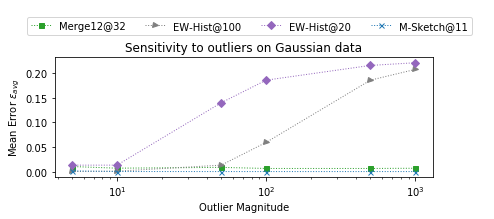

In [126]:
f = plt.figure(figsize=(6,2.3))
ax = f.gca()

lines = []
labels = []
for alg,size in sketches:
    c_df = dfg.loc[alg,size]
    cur_label = "{}@{}".format(alg_display_name[alg], int(size))
    if alg == "histogram":
        cur_color = colormap[(alg, size)]
        cur_marker = markers[(alg, size)]
    else:
        cur_color = colormap[alg]
        cur_marker = markers[alg]
    l, = ax.semilogx(
        c_df.index,
        c_df["error"], 
        label=cur_label,
        marker=cur_marker,
        color=cur_color,
        markersize=5,
        ls="dotted",
        lw=1
    )
    lines.append(l)
    labels.append(cur_label)

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.05, 1.15, 1., .102), ncol=4, loc=2
)
f.tight_layout()
# ax.set_xlim(5, 1000)
ax.set_xlabel("Outlier Magnitude")
ax.set_ylabel("Mean Error $\epsilon_{avg}$")
ax.set_title("Sensitivity to outliers on Gaussian data")
f.savefig("robust_outlier.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')